In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set_style("darkgrid")
sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_csv("CATI_LPK_MASZK_2021_10_hullam_2021_10_compl_20211030_clean_Renyi.csv",
           sep=';',
           header=0)

# Fix data
df = df.replace("Kömlő", "Kömlőd")
df = df.replace("Hódosér (bakonyszentlászló)", "Bakonyszentlászló")

# Merge KSH
KSH = pd.read_csv("HU_places_admin_pop_ZIP_latlon.csv",
           sep=',',
           header=0)
df=pd.merge(df, KSH, left_on="K15A", right_on="place")

# Add central Hungary
pest = ["Budapest"]+["Alsónémedi","Biatorbágy","Budajenő","Budakalász","Budakeszi","Budaörs","Csobánka","Csomád","Csömör","Csörög","Dabas","Délegyháza","Diósd","Dunabogdány","Dunaharaszti","Dunakeszi","Dunavarsány","Ecser","Erdőkertes","Érd","Felsőpakony","Fót","Göd","Gödöllő","Gyál","Gyömrő","Halásztelek","Herceghalom","Inárcs","Isaszeg","Kakucs","Kerepes","Kistarcsa","Kisoroszi","Leányfalu","Majosháza","Maglód","Mogyoród","Monor","Nagykovácsi","Nagytarcsa","Ócsa","Őrbottyán","Páty","Perbál","Pécel","Pilisborosjenő","Piliscsaba","Pilisjászfalu","Pilisszántó","Pilisszentiván","Pilisszentkereszt","Pilisszentlászló","Pilisvörösvár","Pomáz","Pócsmegyer","Pusztazámor","Remeteszőlős","Solymár","Sóskút","Szada","Százhalombatta","Szentendre","Szigethalom","Szigetmonostor","Szigetszentmiklós","Sződ","Sződliget","Tahitótfalu","Taksony","Tárnok","Telki","Tinnye","Tök","Tököl","Törökbálint","Újhartyán","Újlengyel","Üllő","Üröm","Vác","Vácrátót","Vecsés","Veresegyház","Visegrád","Zsámbék"]
no_pest = [k for k in set(df["K15A"].array) if k not in pest]
pest = [k for k in set(df["K15A"].array) if k in pest]

centralHun = pd.DataFrame({
    "central":np.concatenate((np.ones(len(pest), dtype=int), np.zeros(len(no_pest), dtype=int))),
    "K15A":pest+no_pest
})
df=df.merge(centralHun, on="K15A")

In [3]:
import numpy as np

def survey(results, category_names, figsize=(12,8)):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    #category_colors = plt.get_cmap('RdYlGn')(
    category_colors = plt.get_cmap('seismic')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=figsize)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.1 else 'black'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 0.95),
              loc='lower left', fontsize='small')

    return fig, ax

def mysurvey(df, Q_key, Q_name, category_names, figsize=(12,8)):
    results = {}
    for key,name in zip(Q_key, Q_name):
        x = df.groupby([key])['súly'].sum()
        results[name]=np.round(100*x.array/np.sum(x.array), decimals=2)
    survey(results, category_names, figsize)

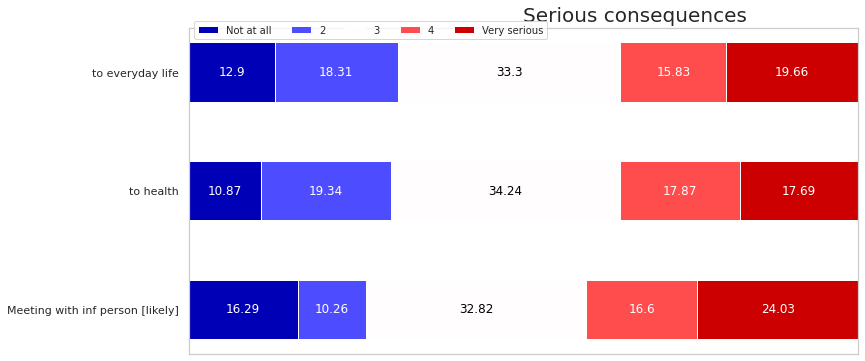

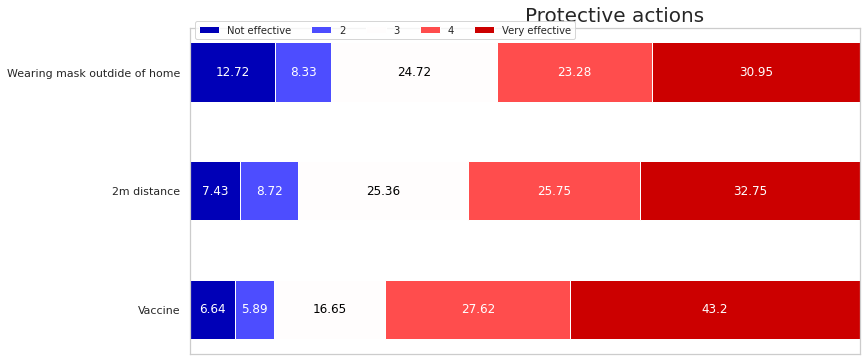

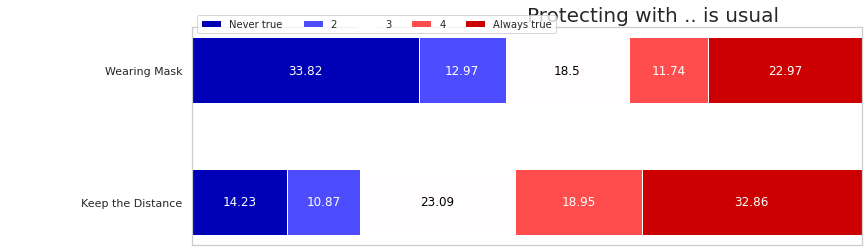

In [4]:
fig=mysurvey(df,
             ['K84', 'K85', 'K86'],
             ["to everyday life", "to health", "Meeting with inf person [likely]"],
             ["Not at all", "2", "3", "4", "Very serious"],figsize=(12,6))

plt.title("Serious consequences", fontsize=20, ha="left")
plt.show()

fig=mysurvey(df,
             ['K87_01', 'K87_02', 'K87_03'],
             ["Wearing mask outdide of home", "2m distance", "Vaccine"],
             ["Not effective", "2", "3", "4", "Very effective"],figsize=(12,6))

plt.title("Protective actions", fontsize=20, ha="left")
plt.show()

fig=mysurvey(df,
             ['K88_01', 'K88_02'],
             ['                            Wearing Mask', 'Keep the Distance'],
             ["Never true", "2", "3", "4", "Always true"],figsize=(12,4))

plt.title("Protecting with .. is usual", fontsize=20, ha="left")
plt.show()

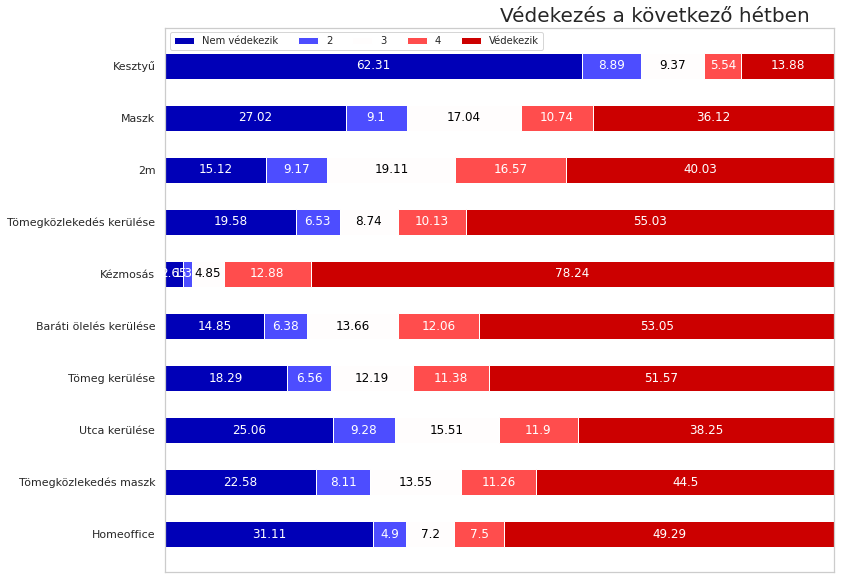

In [5]:
fig=mysurvey(df,
             ["K93_0{}".format(i) for i in range(1,10)]+["K93_11", "K93_12", "K93_13"],
             ['Kesztyű', 'Maszk', '2m', 'Tömegközlekedés kerülése', "Kézmosás", "Baráti ölelés kerülése", "Tömeg kerülése", "Utca kerülése", "Tömegközlekedés maszk", "Homeoffice"],
             ["Nem védekezik", "2", "3", "4", "Védekezik"],figsize=(12,10))

plt.title("Védekezés a következő hétben", fontsize=20, ha="left")
plt.show()

In [6]:
labels_bp = ["Budapest aggl.", "vidék"]
criterions_bp = [df["central"]==ctype for ctype in [1,0]]

age_arr = [(18,29), (30,44),(45, 60), (60,69), (70,79), (80,100)]
criterions_age = [(df["SZUL"]>=a) & (df["SZUL"]<=b) for a,b in age_arr]
labels_age = [f"Age ({a}-{b})" for (a,b),c in zip(age_arr, criterions_age)]

labels_oltott = ["nem oltott", "1 oltás", "2 oltás", "3 oltás"]
criterions_oltott = [df["K24"]==2, df["K25_1"]==1, df["K25_1"]==2, df["K25_1"]==3]

In [7]:
def survey_criterions(df, key, labels, criterions, category_names, figsize=(12,8)):
    results = {}
    for label,crit in zip(labels, criterions):
        x = df[crit].groupby([key])['súly'].sum()
        n = list(set(range(1,6))-set(list(x.index)))
        x = x.append(pd.Series(np.zeros(len(n)), index=n))
        results[label+f" [#{len(df[crit])}]"]=np.round(100*x.array/np.sum(x.array), decimals=2)
        #print(label, results[label], x.index, x.array)
    survey(results, category_names, figsize)

# Consequences

* 1 olottak nagyon fircsán viselkednek. Lehet érdemes lenne leszűrni a Jansseneseket

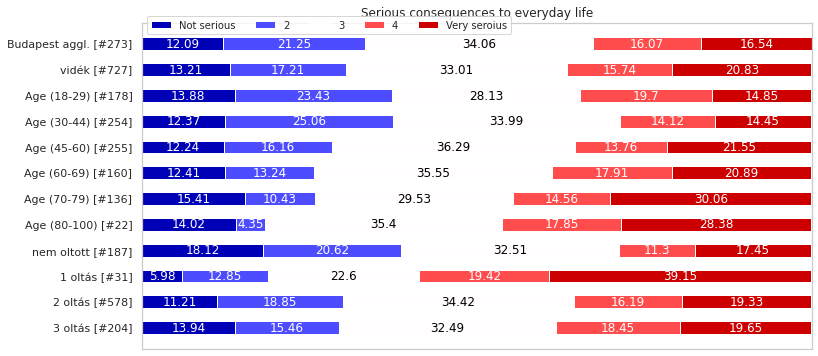

In [8]:
survey_criterions(df, "K84",
                  labels=labels_bp+labels_age+labels_oltott,
                  criterions=criterions_bp+criterions_age+criterions_oltott,
                  category_names= ["Not serious", "2", "3", "4", "Very seroius"],
                  figsize=(12,6))
plt.title("Serious consequences to everyday life")
plt.show()

Age80-100 -nál  összecsúszott a 4-5. kategória


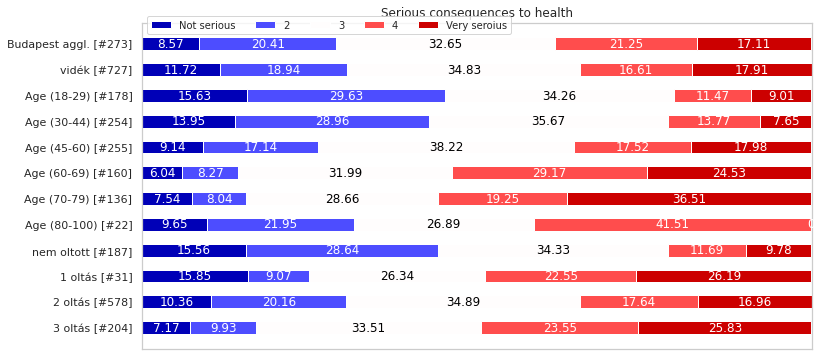

In [9]:
print("Age80-100 -nál  összecsúszott a 4-5. kategória")
survey_criterions(df, "K85",
                  labels=labels_bp+labels_age+labels_oltott,
                  criterions=criterions_bp+criterions_age+criterions_oltott,
                  category_names= ["Not serious", "2", "3", "4", "Very seroius"],
                  figsize=(12,6))
plt.title("Serious consequences to health")
plt.show()

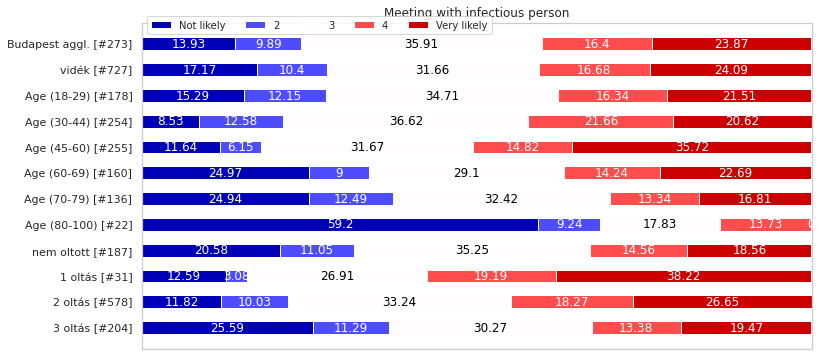

In [10]:
survey_criterions(df, "K86",
                  labels=labels_bp+labels_age+labels_oltott,
                  criterions=criterions_bp+criterions_age+criterions_oltott,
                  category_names= ["Not likely", "2", "3", "4", "Very likely"],
                  figsize=(12,6))
plt.title("Meeting with infectious person")
plt.show()

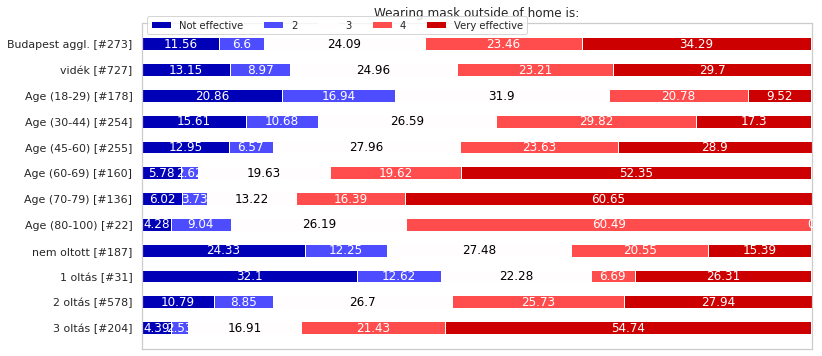

In [11]:
survey_criterions(df, "K87_01",
                  labels=labels_bp+labels_age+labels_oltott,
                  criterions=criterions_bp+criterions_age+criterions_oltott,
                  category_names= ["Not effective", "2", "3", "4", "Very effective"],
                  figsize=(12,6))
plt.title("Wearing mask outside of home is:")
plt.show()

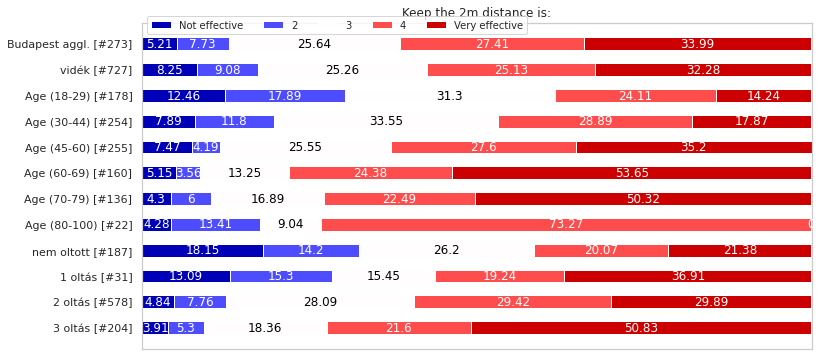

In [12]:
survey_criterions(df, "K87_02",
                  labels=labels_bp+labels_age+labels_oltott,
                  criterions=criterions_bp+criterions_age+criterions_oltott,
                  category_names= ["Not effective", "2", "3", "4", "Very effective"],
                  figsize=(12,6))
plt.title("Keep the 2m distance is:")
plt.show()

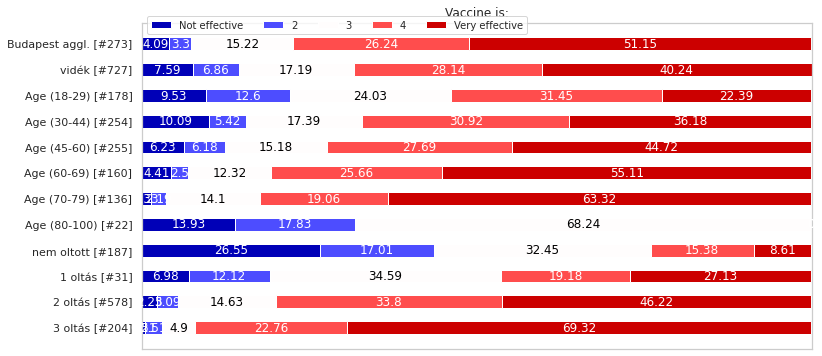

In [13]:
survey_criterions(df, "K87_03",
                  labels=labels_bp+labels_age+labels_oltott,
                  criterions=criterions_bp+criterions_age+criterions_oltott,
                  category_names= ["Not effective", "2", "3", "4", "Very effective"],
                  figsize=(12,6))
plt.title("Vaccine is:")
plt.show()

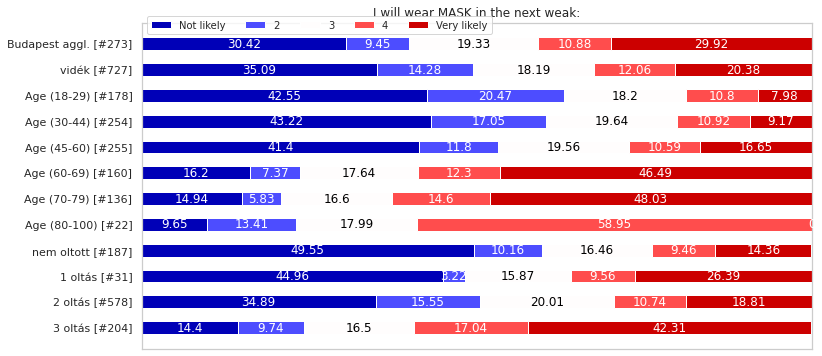

In [14]:
survey_criterions(df, "K88_01",
                  labels=labels_bp+labels_age+labels_oltott,
                  criterions=criterions_bp+criterions_age+criterions_oltott,
                  category_names= ["Not likely", "2", "3", "4", "Very likely"],
                  figsize=(12,6))
plt.title("I will wear MASK in the next weak:")
plt.show()

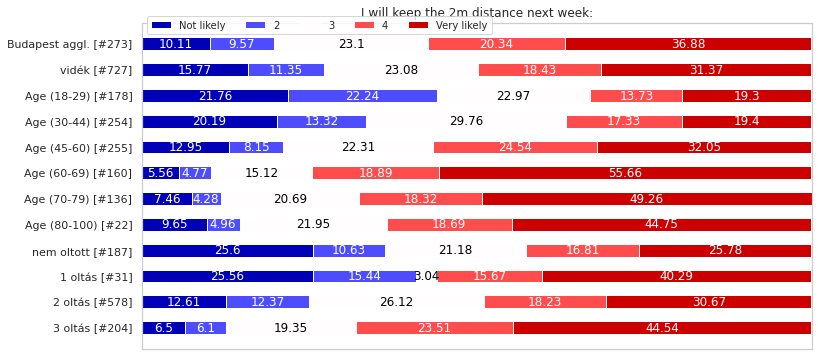

In [15]:
survey_criterions(df, "K88_02",
                  labels=labels_bp+labels_age+labels_oltott,
                  criterions=criterions_bp+criterions_age+criterions_oltott,
                  category_names= ["Not likely", "2", "3", "4", "Very likely"],
                  figsize=(12,6))
plt.title("I will keep the 2m distance next week:")
plt.show()